In [1]:
from common import colors, sbarlw, insetlw

In [2]:
import os
os.chdir(os.path.join('..', '..', '..'))
print(os.getcwd())

/Users/eharkin/Documents/projects/5HTGIF


In [3]:
from __future__ import division

import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import pandas as pd

from grr.cell_class import (
    Cell,
    Recording,
    subtract_baseline,
    subtract_leak,
)
from grr import pltools
from grr.CurveFit import fit_decay_curve, fit_gating_curve, plot_linear_fit
from grr.Tools import dashedBorder, timeToIndex

In [4]:
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'fig1')
NOTEBOOK_PATH = os.path.join('figs', 'scripts', 'writeup')

plt.style.use(os.path.join(NOTEBOOK_PATH, 'publication_figure_style.dms'))

In [5]:
# Load V-steps files for sample pharma traces.
baseline = Cell().read_ABF('./data/raw/figdata/18411010.abf')[0]
baseline.set_dt(0.1)
TEA = Cell().read_ABF('./data/raw/figdata/18411013.abf')[0]
TEA.set_dt(0.1)
TEA_4AP = Cell().read_ABF('./data/raw/figdata/18411015.abf')[0]
TEA_4AP.set_dt(0.1)

GATING_PATH = './data/raw/5HT/gating/'

# Load gating data
gating = Cell().read_ABF([GATING_PATH + '18411002.abf',
                          GATING_PATH + '18411010.abf',
                          GATING_PATH + '18411017.abf',
                          GATING_PATH + '18411019.abf',
                          GATING_PATH + 'c0_inact_18201021.abf',
                          GATING_PATH + 'c1_inact_18201029.abf',
                          GATING_PATH + 'c2_inact_18201034.abf',
                          GATING_PATH + 'c3_inact_18201039.abf',
                          GATING_PATH + 'c4_inact_18213011.abf',
                          GATING_PATH + 'c5_inact_18213017.abf',
                          GATING_PATH + 'c6_inact_18213020.abf',
                          GATING_PATH + '18619018.abf',
                          GATING_PATH + '18614032.abf'])

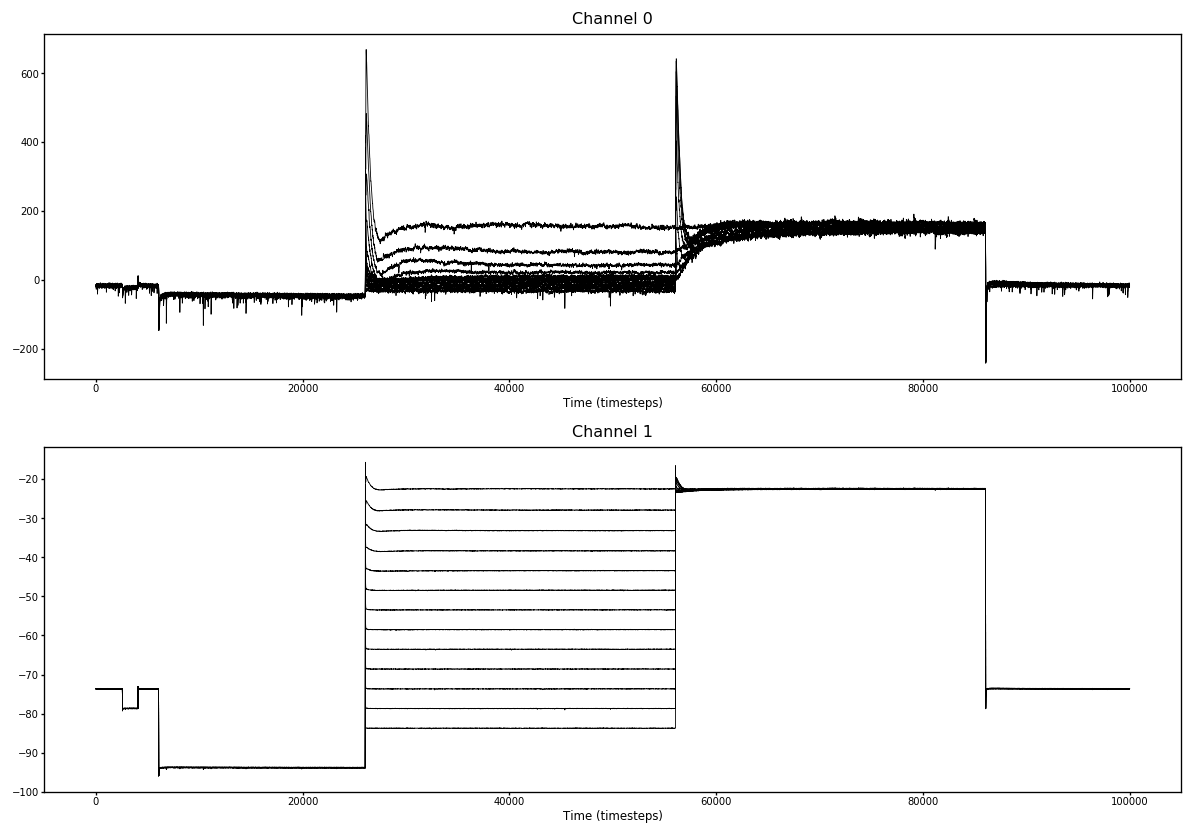

In [6]:
gating[0].plot()

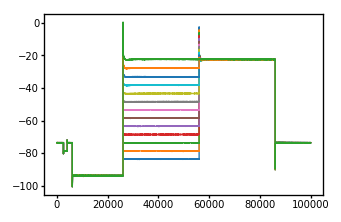

In [7]:
t_vec = np.arange(0, gating[0].shape[1] * 0.1)
plt.plot(gating[0][1, :, :])

In [8]:
print(gating[0][1, 0, :])
print(gating[0][1, 20000, :])
print(gating[0][1, 40000, :])

[-73.63891602 -73.66943359 -73.60839844 -73.63891602 -73.66943359
 -73.60839844 -73.66943359 -73.63891602 -73.60839844 -73.66943359
 -73.66943359 -73.63891602 -73.60839844]
[-93.84155273 -93.90258789 -93.90258789 -93.90258789 -93.90258789
 -93.84155273 -93.81103516 -93.84155273 -93.81103516 -93.84155273
 -93.90258789 -93.84155273 -93.78051758]
[-83.77075195 -78.76586914 -73.69995117 -68.60351562 -63.53759766
 -58.50219727 -53.4362793  -48.37036133 -43.42651367 -38.33007812
 -33.203125   -27.89306641 -22.4609375 ]


# Subtract baseline/leak

In [9]:
baseline = subtract_baseline(baseline, slice(1000, 2000), 0)
baseline = subtract_leak(baseline, slice(1000, 2000), slice(3000, 3400))
baseline.set_dt(0.1)

TEA_4AP = subtract_baseline(TEA_4AP, slice(1000, 2000), 0)
TEA_4AP = subtract_leak(TEA_4AP, slice(1000, 2000), slice(3000, 3400))
TEA_4AP.set_dt(0.1)

gating_tmp = []
for rec in gating:
    baseline_subtracted = subtract_baseline(rec, slice(1000, 2000), 0)
    leak_subtracted = subtract_leak(baseline_subtracted, slice(1000, 2000), slice(3000, 3400))
    leak_subtracted.set_dt(0.1)
    gating_tmp.append(leak_subtracted)
gating = gating_tmp
del gating_tmp, baseline_subtracted, leak_subtracted 

# Fit decay

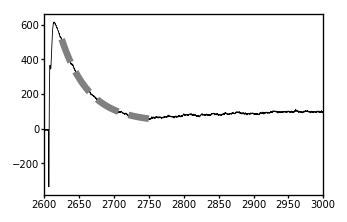

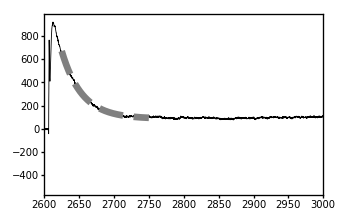

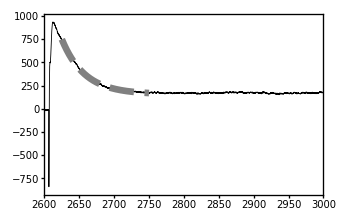

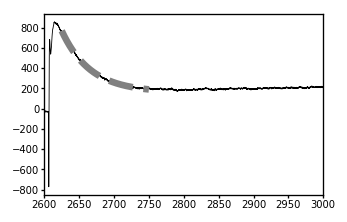

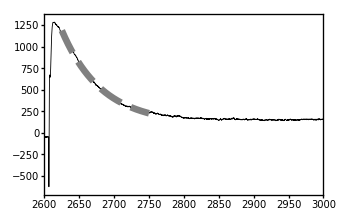

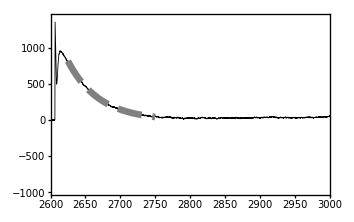

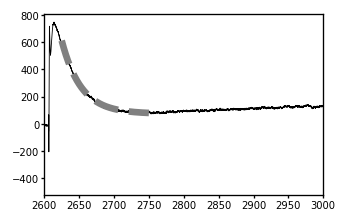

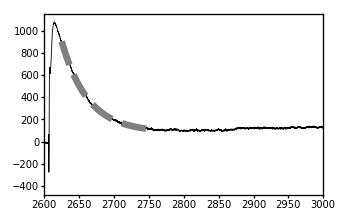

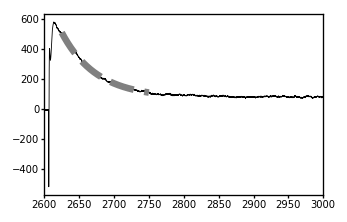

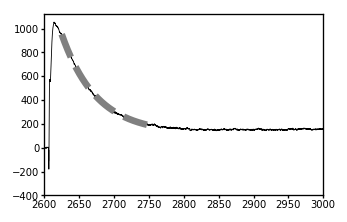

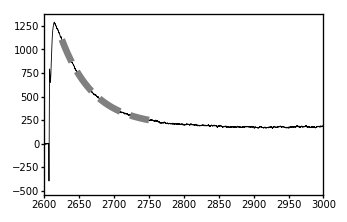

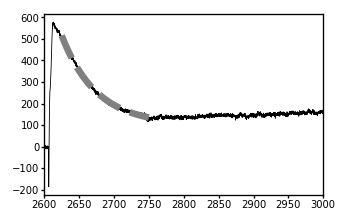

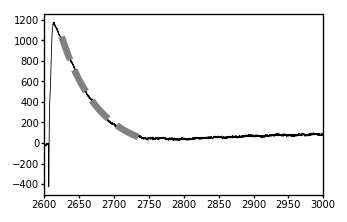

IA inactivation tau 42.9 +/- 9.0 (mean +/- SD)


In [10]:
step_amplitude = 50  # 70mV (-70 to -20)

IA_inactivation = {
    'traces': [],
    'fitted_data': [],
    'fitted_curves': [], 
    'range_fitted': [],
    'inactivation_taus': [],
    'peak_latencies': [],
    'peak_amplitudes': [],
    'steady_state_amplitudes': [],
    'peak_exists': []
}

peak_fit_params = {
    'stimulus_start_time': 2606.2,
    'steady_state_time': 3606.2,
    'peak_slice': slice(26085, 30000),
    'decay_slice': slice(26250, 27500)
}

for i in range(len(gating)):
    
    # Determine whether there is a peak using same method as for GABA.
    peak_inds = find_peaks(
        gating[i][0, peak_fit_params['peak_slice'], -1],
        distance=500,
        prominence=50.,
        width=100
    )[0]
    if len(peak_inds) > 0:
        if len(peak_inds) > 1:
            warnings.warn(
                '{} peaks detected for recording {}.'.format(len(peak_inds), i)
            )
        peak_exists = True
    else:
        peak_exists = False
    IA_inactivation['peak_exists'].append(peak_exists)
    
    # Find peak latency
    IA_inactivation['peak_latencies'].append(
        np.argmax(gating[i][0, peak_fit_params['peak_slice'], -1]) * 0.1 
        + peak_fit_params['peak_slice'].start * 0.1 
        - peak_fit_params['stimulus_start_time']
    )
    
    # Get peak amplitude.
    IA_inactivation['peak_amplitudes'].append(
        gating[i][
            0, 
            np.argmax(gating[i][0, peak_fit_params['peak_slice'], -1]) + peak_fit_params['peak_slice'].start, 
            -1
        ]
    )
    
    # Get steady-state amplitude
    IA_inactivation['steady_state_amplitudes'].append(
        gating[i][0, timeToIndex(peak_fit_params['steady_state_time'], 0.1)[0], -1]
    )
    
    # Fit decay
    IA_inactivation['range_fitted'].append([peak_fit_params['decay_slice'].start * 0.1, peak_fit_params['decay_slice'].stop * 0.1])

    t_vec = np.arange(0, gating[i].shape[1], 0.1)[:gating[i].shape[1]]
    fitted_tmp = gating[i][0, peak_fit_params['decay_slice'], -1]
    IA_inactivation['fitted_data'].append(np.array(
        [fitted_tmp,
        t_vec[peak_fit_params['decay_slice']]]
    ))

    IA_inactivation['traces'].append(np.array([gating[i][0, :, -1], gating[i][1, :, -1], t_vec]))

    p_tmp, fitted_tmp = fit_decay_curve(
        fitted_tmp,
        [fitted_tmp[0] - fitted_tmp[-1], fitted_tmp[-1], 20],
        dt = 0.1
    )

    IA_inactivation['inactivation_taus'].append(p_tmp[2])
    IA_inactivation['fitted_curves'].append(np.array(
        [fitted_tmp[0, :],
        np.linspace(peak_fit_params['decay_slice'].start * 0.1, peak_fit_params['decay_slice'].stop * 0.1, len(fitted_tmp[0, :]))]
    ))

    # Diagnostic plot of decay fit.
    plt.figure()
    plt.plot(t_vec, gating[i][0, :, -1], 'k-', lw=0.5)
    #plt.plot(t_vec[peak_fit_params['decay_slice']], gating[i][0, peak_fit_params['decay_slice'], -1], 'r-')
    plt.plot(
        np.linspace(
            peak_fit_params['decay_slice'].start * 0.1, peak_fit_params['decay_slice'].stop * 0.1, len(fitted_tmp[0, :])
        ),
        fitted_tmp[0, :], '--', color = 'gray', lw=4
    )
    plt.xlim(2600, 3000)
    plt.show()


for key in IA_inactivation:
    IA_inactivation[key] = np.array(IA_inactivation[key])
print('IA inactivation tau {:.1f} +/- {:.1f} (mean +/- SD)'.format(
    IA_inactivation['inactivation_taus'].mean(), IA_inactivation['inactivation_taus'].std()
))

#with open(PROCESSED_PATH + 'inactivation_fits.dat', 'wb') as f:
#    pickle.dump(IA_inactivation, f)

In [11]:
IA_inactivation.keys()

['peak_latencies',
 'steady_state_amplitudes',
 'inactivation_taus',
 'peak_amplitudes',
 'peak_exists',
 'fitted_data',
 'fitted_curves',
 'traces',
 'range_fitted']

In [12]:
for dataset in ['peak_amplitudes', 'peak_latencies', 'steady_state_amplitudes', 'inactivation_taus']:
    print('{:>25} {:>10.3} +/- {:>5.3}'.format(
        dataset, 
        np.mean(IA_inactivation[dataset]), 
        stats.sem(IA_inactivation[dataset])
    ))

          peak_amplitudes   9.29e+02 +/-  69.0
           peak_latencies       7.46 +/- 0.207
  steady_state_amplitudes   1.42e+02 +/-  12.6
        inactivation_taus       42.9 +/-   2.6


## Summary statistics for quantities in nS

In [13]:
print('Peak amplitudes (nS) {:>20.3} +/- {:>5.3}'.format(
    np.mean(IA_inactivation['peak_amplitudes'] / step_amplitude),
    stats.sem(IA_inactivation['peak_amplitudes'] / step_amplitude)
))
print('Steady state amplitudes (nS) {:>20.3} +/- {:>5.3}'.format(
    np.mean(IA_inactivation['steady_state_amplitudes'] / step_amplitude),
    stats.sem(IA_inactivation['steady_state_amplitudes'] / step_amplitude)
))

Peak amplitudes (nS)                 18.6 +/-  1.38
Steady state amplitudes (nS)                 2.84 +/- 0.252


# Table of extracted parameters

In [14]:
IA_inactivation['steady_state_conductance'] = IA_inactivation['steady_state_amplitudes'] / step_amplitude
IA_inactivation['peak_conductance'] = IA_inactivation['peak_amplitudes'] / step_amplitude

In [17]:
statistics = [
    'peak_latencies', 
    'steady_state_amplitudes', 
    'steady_state_conductance', 
    'peak_conductance',
    'peak_amplitudes',
    'inactivation_taus',
    'peak_exists'
]
stats_df = pd.DataFrame({key: IA_inactivation[key] for key in statistics})

In [18]:
stats_df

,inactivation_taus,peak_amplitudes,peak_conductance,peak_exists,peak_latencies,steady_state_amplitudes,steady_state_conductance
0,39.280178,616.019392,12.320388,True,7.7,97.607349,1.952147
1,28.866688,921.168675,18.423373,True,6.3,107.386440,2.147729
2,32.445161,935.471419,18.709428,True,5.8,170.499481,3.409990
3,40.782865,855.081312,17.101626,True,8.3,220.519097,4.410382
4,57.185123,1287.397250,25.747945,True,7.9,155.052318,3.101046
5,44.690907,952.393451,19.047869,True,7.5,62.802801,1.256056
6,27.602526,749.077922,14.981558,True,7.8,151.887616,3.037752
7,37.392290,1076.172008,21.523440,True,8.0,160.327488,3.206550
8,49.518003,576.848941,11.536979,True,7.7,89.449190,1.788984
9,49.753422,1055.642518,21.112850,True,7.8,167.120445,3.342409


In [19]:
stats_df.mean()

inactivation_taus            42.868023
peak_amplitudes             928.714661
peak_conductance             18.574293
peak_exists                   1.000000
peak_latencies                7.461538
steady_state_amplitudes     141.791420
steady_state_conductance      2.835828
dtype: float64

In [20]:
stats_df.std()

inactivation_taus             9.371580
peak_amplitudes             248.833994
peak_conductance              4.976680
peak_exists                   0.000000
peak_latencies                0.746702
steady_state_amplitudes      45.446003
steady_state_conductance      0.908920
dtype: float64

In [21]:
stats_df.sem()

inactivation_taus            2.599209
peak_amplitudes             69.014133
peak_conductance             1.380283
peak_exists                  0.000000
peak_latencies               0.207098
steady_state_amplitudes     12.604453
steady_state_conductance     0.252089
dtype: float64

Save to CSV.

In [19]:
stats_df.to_csv(os.path.join('data', 'processed', '5HT', 'transient_current_parameters.csv'), index=False)

# Figures

/miniconda3/envs/neopozz/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


IOError: [Errno 13] Permission denied: 'figs/ims/writeup/fig1/ser_kinetics_trace_only.svg'

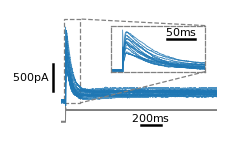

In [20]:
fit_example_no = 5
bg_tr_alpha = 0.8

tr_spec = gs.GridSpec(2, 1, height_ratios=[1, 0.2], hspace=0, top=0.97, bottom=0.05, right=0.97, left=0.1)

plt.figure(figsize=(1.5, 1))

wc_ax = plt.subplot(tr_spec[0, :])
plt.plot(
    (IA_inactivation['traces'][:, 2, :].T - 2606.2), 
    IA_inactivation['traces'][:, 0, :].T,
    '-', color=colors['ser'], lw=0.5, alpha=bg_tr_alpha
)
plt.xlim(-50, 1550)
plt.ylim(-100, 1600)
pltools.add_scalebar(y_units='pA', omit_x=True, anchor=(-0.05, 0.1), linewidth=sbarlw)
sns.despine(ax=plt.gca(), trim=True)

wc_ins = inset_axes(wc_ax, '60%', '50%', loc='upper right', borderpad=1.2)
plt.plot(
    (IA_inactivation['traces'][:, 2, :].T - 2606.2), 
    IA_inactivation['traces'][:, 0, :].T,
    '-', color=colors['ser'], lw=0.5, alpha=bg_tr_alpha
)
plt.xlim(-20, 150)
plt.ylim(-50, 1500)
pltools.add_scalebar(x_units='ms', omit_y=True, anchor=(0.95, 0.7), x_label_space=0.05, remove_frame=False, linewidth=sbarlw)
plt.xticks([])
plt.yticks([])
dashedBorder(wc_ins, lw=insetlw)
mark_inset(wc_ax, wc_ins, 1, 4, ls='--', color='gray', lw=insetlw)

plt.subplot(tr_spec[1, :])
plt.plot(
    (IA_inactivation['traces'][:, 2, :].T - 2606.2), 
    IA_inactivation['traces'][:, 1, :].T,
    '-', color=colors['input'], lw=0.5, alpha=bg_tr_alpha
)
plt.xlim(-50, 1550)
pltools.add_scalebar(x_units='ms', x_size=200, omit_y=True, anchor=(0.7, -0.05), x_label_space=0.05, linewidth=sbarlw)

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'ser_kinetics_trace_only.png'))
    plt.savefig(os.path.join(IMG_PATH, 'ser_kinetics_trace_only.svg'))
    
plt.show()

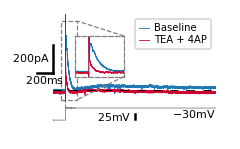

In [32]:
Kslow_xlim = (2450, 8500)

spec_pharm = gs.GridSpec(2, 1, height_ratios=[1, 0.2], hspace=0, left=0.15, bottom=0.05, top=0.95, right=0.95)

plt.figure(figsize=(1.7, 1))

pharm_ax = plt.subplot(spec_pharm[0, :])
plt.plot(
    baseline.t_mat[0, :, -3],
    baseline[0, :, -3],
    linewidth = 0.5, color = colors['ser'],
    label = 'Baseline'
)
plt.plot(
    TEA_4AP.t_mat[0, :, -3],
    TEA_4AP[0, :, -3],
    linewidth = 0.5, color = colors['4AP'],
    label = 'TEA + 4AP'
)
plt.axhline(0, ls = '--', lw = 0.5, color = 'k', dashes = (10, 10))
plt.xlim(Kslow_xlim[0], 4500)
plt.ylim(-100, 550)
pltools.add_scalebar(
    'ms', 'pA', anchor = (0, 0.35), y_size = 200, x_size = 200,
    bar_space = 0, x_label_space = -0.02, linewidth=sbarlw
)
plt.legend()

pharm_ins = inset_axes(pharm_ax, '30%', '45%', loc = 'upper left', borderpad = 2.2)
plt.plot(
    baseline.t_mat[0, :, -3],
    baseline[0, :, -3],
    linewidth = 0.5, color = colors['ser'],
    label = 'Baseline'
)
plt.plot(
    TEA_4AP.t_mat[0, :, -3],
    TEA_4AP[0, :, -3],
    linewidth = 0.5, color = colors['4AP'],
    label = 'TEA + 4AP'
)
plt.xlim(Kslow_xlim[0] + 100, Kslow_xlim[0] + 300)
plt.ylim(-70, 500)
dashedBorder(pharm_ins, lw=insetlw)
pltools.hide_ticks()
mark_inset(pharm_ax, pharm_ins, loc1 = 1, loc2 = 4, ls = '--', color = 'gray', lw = insetlw)

plt.subplot(spec_pharm[1, :])
plt.plot(
    baseline.t_mat[1, :, -3],
    baseline[1, :, -3],
    linewidth = 0.5, color = 'gray'
)
pltools.add_scalebar(y_units = 'mV', anchor = (0.5, 0.1), omit_x = True, y_size = 25, linewidth=sbarlw)
plt.text(4500, -32, '$-30$mV', ha = 'right', va = 'top', size = 'small')
plt.xlim(Kslow_xlim[0], 4500)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'ser_pharmacology.png'))
    plt.savefig(os.path.join(IMG_PATH, 'ser_pharmacology.svg'))